In [363]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import pandas as pd
import os

In [364]:
# File Path
train_data_path = './archive/Train.csv'
test_data_path = './archive/Test.csv'
train_raw_data = pd.read_csv(train_data_path)
test_raw_data = pd.read_csv(test_data_path)

In [365]:
# Data Preprocessing
# Resize Image
def resize_with_aspect_ratio(image, target_size):
    target_width, target_height = target_size
    h, w = image.shape
    scale = min(target_width / w, target_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resize = cv2.resize(image, (new_w, new_h))
    pad_left = (target_width - new_w) // 2
    pad_right = target_width - new_w - pad_left
    pad_top = (target_height - new_h) // 2
    pad_bottom = target_height - new_h - pad_top
    padded_image = cv2.copyMakeBorder(resize, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
    return padded_image

# Extract ROI of each image
def preprocessImage(img_data, target_size):
    image_array = []
    class_list = []
    for index, row in img_data.iterrows():
        image_path = os.path.join('./archive', row['Path'])
        class_id = row['ClassId']
        class_list.append(class_id)
        image = cv2.imread(image_path)
        x1,y1,x2,y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
        image_roi = image[y1:y2, x1:x2]
        # Convert to grayscale
        gray_image = cv2.cvtColor(image_roi, cv2.COLOR_BGR2GRAY)
        # Resize Image
        resized = resize_with_aspect_ratio(gray_image, target_size)
        # Flatten Image
        fattened_image = resized.flatten()
        image_array.append(fattened_image.reshape(-1,1))
    return image_array, class_list

In [366]:
# Training Set
TARGET_SIZE = (64, 64)
# Training: data & classes
train_data,train_class = preprocessImage(train_raw_data, TARGET_SIZE)
# Training: number of images
train_num_img = len(train_data)
train_data = np.hstack(train_data)
# Training: number of classes
train_num_class = len(set(train_class))
train_class = np.asarray(train_class)

In [367]:
# Test Set
TARGET_SIZE = (64, 64)
# Test: data & classes
test_data,test_class = preprocessImage(test_raw_data, TARGET_SIZE)
# Test: number of images
test_num_img = len(test_data)
test_data = np.hstack(test_data)
# Test: number of classes
test_num_class = len(set(test_class))
test_class = np.asarray(test_class)

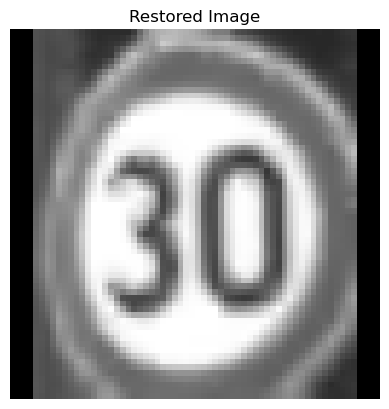

In [368]:
# Check Image
def check_resolution(data, size, index):
    pic = data[:,index]
    pic = pic.reshape(size[0],size[1])
    plt.imshow(pic, cmap='gray')
    plt.title("Restored Image")
    plt.axis("off")
    plt.show()
check_resolution(test_data, TARGET_SIZE, 1)


In [369]:
# PCA
def pca(pixel, k=0):
    m,n = pixel.shape
    # Normalize
    mean = np.mean(pixel, axis=1, keepdims=True)
    pixel_norm = pixel - mean
    # Covariance Matrix
    Q = np.dot(pixel_norm, pixel_norm.T) / n
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    # Eigenvectors & Eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # Keep the top-k eigenvalue and eigenvector
    eigenvectors = eigenvectors[:,:k] if k != 0 else eigenvectors
    eigenvalues = eigenvalues[:k] if k != 0 else eigenvalues
    # Principle Component QV
    principal_components = np.dot(eigenvectors.T, pixel_norm)
    # Reconstruct Image
    reconstruct = np.dot(eigenvectors, principal_components) + mean

    return eigenvectors, eigenvalues, principal_components, reconstruct

In [370]:
# LDA
def lda(data, classes):
    num_classes = len(np.unique(classes))
    total_mean = np.mean(data, axis=1, keepdims=True)
    Sw = None
    Sb = None
    for c in np.unique(classes):
        indices = [i for i, val in enumerate(classes) if val == c]
        selected_data = data[:, indices]
        # Mean of Class
        class_mean = np.mean(selected_data, axis=1, keepdims=True)
        selected_data = selected_data - class_mean
        # Sw: Scatter matrix within class
        Sw_i = np.dot(selected_data, selected_data.T)
        if Sw is None:
            Sw = Sw_i
        else:
            Sw += Sw_i
        # Sb: Scatter matrix between class
        num_samples = selected_data.shape[1]
        Sb_i = num_samples * np.dot((class_mean - total_mean), (class_mean - total_mean).T)
        if Sb is None:
            Sb = Sb_i
        else:
            Sb += Sb_i

    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    k = num_classes - 1
    eigvals = eigvals[:k]
    eigvecs = eigvecs[:, :k]
    projection = np.dot(eigvecs.T, data)
    return eigvecs,eigvals, projection


In [371]:
# Process Training data with PCA
K = 481
train_mean_pca = np.mean(train_data, axis=1, keepdims=True)
train_pca_eigen_vect,train_pca_eigen_val,train_pca_principle_components, train_reconstruct = pca(train_data,k=K)

In [372]:
# Process Training data with LDA
train_mean_lda = np.mean(train_pca_principle_components, axis=1, keepdims=True)
train_lda_eigen_vect, train_lda_eigen_val, train_lda_proj = lda(train_pca_principle_components, train_class)


In [373]:
# Process Test data with PCA
test_data = test_data - train_mean_pca
test_pca_principle_components = np.dot(train_pca_eigen_vect.T, test_data)
# Process Test data with LDA
test_lda_proj = np.dot(train_lda_eigen_vect.T, test_pca_principle_components)


In [378]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

X_train_lda_T = train_lda_proj.T
X_test_lda_T = test_lda_proj.T
X_train_lda_T = X_train_lda_T.real
X_test_lda_T = X_test_lda_T.real
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=1,weights='distance')

# Fit training data
knn.fit(X_train_lda_T, train_class)

# Predict test data
y_pred = knn.predict(X_test_lda_T)

# Accuracy
accuracy = accuracy_score(test_class, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_mat = confusion_matrix(test_class, y_pred)
print("Confusion Matrix:")
print(conf_mat)


Accuracy: 0.8989707046714173
Confusion Matrix:
[[ 45   0   0 ...   0   0   0]
 [  1 676  11 ...   0   0   0]
 [  0  16 696 ...   2   0   0]
 ...
 [  0   3   1 ...  62   0   0]
 [  0   0   0 ...   0  51   0]
 [  0   0   0 ...   0   1  88]]
